In [267]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/class_financial-econometrics


In [268]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import math 
import numpy as np
from pandas_datareader import data as pdr
import os



In [269]:
plt.style.use("../styler.mplstyle") 

In [270]:
data = [
        'INDPRO', # gdp growth 
        'CPIAUCSL',
        'FEDFUNDS' # federal funds 
        ]

In [271]:
df = pdr.DataReader(
    data,
    "fred",
    start="1970-01-01",
    end="2025-07-01",
).astype(float)

In [272]:
# df['GDP_r'] =  100 * df['GDPC1'].diff()
df["y"]  = 100 * (np.log(df["INDPRO"]).diff())

# inflation pi_t (monthly log inflation * 100)
# df["pi"] = 100 * (np.log(df["CPIAUCSL"]).diff())
df['pi'] = 400 * np.log(df['CPIAUCSL']/ df['CPIAUCSL'].shift())

# fed funds i_t in level (%)
df["i"]  = df["FEDFUNDS"]

## 1

In [273]:
Z = df[["y","pi","i"]].dropna()
Z.head()

,y,pi,i
DATE,,,
1970-02-01,-0.065820,2.105268,8.98
1970-03-01,-0.129924,2.094246,7.76
1970-04-01,-0.257448,2.083338,8.10
1970-05-01,-0.116664,1.037614,7.95
1970-06-01,-0.323985,2.067188,7.61


In [274]:
model = VAR(Z)

/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [275]:
# pick lags (try AIC/BIC)
lag_sel = model.select_order(maxlags=12)
print(lag_sel.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        2.929       2.949       18.71       2.937
1       -1.525      -1.442      0.2177      -1.493
2       -1.702     -1.558*      0.1823      -1.646
3       -1.744      -1.538      0.1749     -1.664*
4       -1.747      -1.480      0.1743      -1.643
5       -1.748      -1.419      0.1741      -1.620
6       -1.742      -1.351      0.1752      -1.590
7       -1.741      -1.289      0.1754      -1.566
8       -1.731      -1.217      0.1771      -1.532
9       -1.783      -1.207      0.1682      -1.559
10      -1.791      -1.153      0.1668      -1.544
11      -1.791      -1.092      0.1669      -1.520
12     -1.800*      -1.039     0.1653*      -1.505
--------------------------------------------------


In [276]:
p = lag_sel.selected_orders["bic"]  # or "aic"
res = model.fit(p)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Dec, 2025
Time:                     18:37:03
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.56882
Nobs:                     664.000    HQIC:                  -1.65595
Log likelihood:          -2237.45    FPE:                   0.180671
AIC:                     -1.71108    Det(Omega_mle):        0.175075
--------------------------------------------------------------------
Results for equation y
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.179595         0.060923            2.948           0.003
L1.y          0.256565         0.039210            6.543           0.000
L1.pi         0.116811         0.036799            3.174           0.002
L1.i          0.198954 

In [277]:
U = res.resid.values              # u_t
Sigma_u = res.sigma_u.values      # Σ_u

B = np.linalg.cholesky(Sigma_u)   # Σ_u = B B'
E = U @ np.linalg.inv(B).T        # e_t = P^{-1} u_t

mp_shock = pd.Series(E[:, 2], index=res.resid.index,
                     name="Monetary policy shock (e_i)")


E = pd.DataFrame(E, index=res.resid.index, columns=[f"shock_{v}" for v in res.names])
# With ordering (y,pi,i): shock_i is monetary policy shock under recursive ID
E.columns = ["e_y", "e_pi", "e_i"]


### 1.e

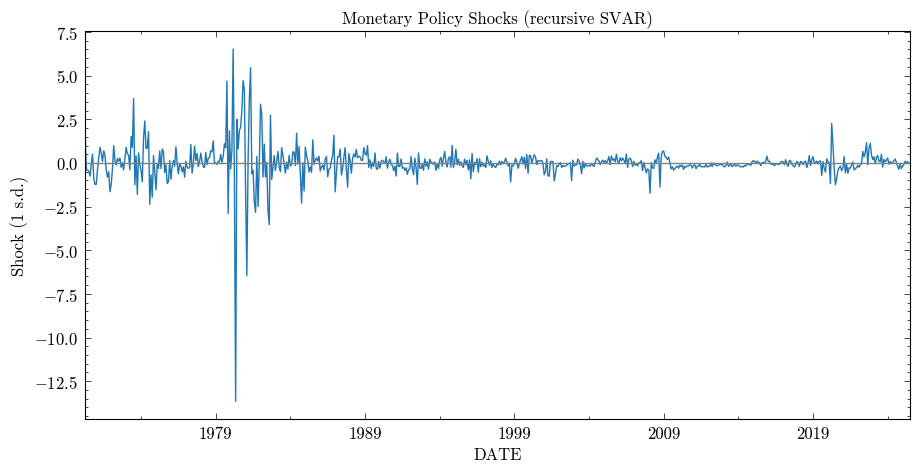

In [278]:

fig, ax = plt.subplots(figsize=(10, 5))
mp_shock.plot(ax=ax, linewidth=1)
ax.axhline(0, linewidth=1, color='grey')
ax.set_title("Monetary Policy Shocks (recursive SVAR)")
ax.set_ylabel("Shock (1 s.d.)")

plt.savefig(f'../Figures/final/mp_shock.png', dpi = 600)
plt.show()

### 1.g

In [279]:
B

array([[0.9235224 , 0.        , 0.        ],
       [0.09364477, 0.97400239, 0.        ],
       [0.07866095, 0.02058787, 0.46516269]])

In [280]:
H = 120 
fevd = res.fevd(H)

In [281]:
fevd.summary()

FEVD for y
              y        pi         i
0      1.000000  0.000000  0.000000
1      0.976230  0.014705  0.009065
2      0.970684  0.014953  0.014363
3      0.969052  0.016276  0.014671
4      0.968541  0.016750  0.014708
5      0.968237  0.016885  0.014878
6      0.967975  0.016938  0.015087
7      0.967731  0.016962  0.015307
8      0.967503  0.016972  0.015525
9      0.967290  0.016976  0.015734
10     0.967093  0.016977  0.015930
11     0.966908  0.016977  0.016116
12     0.966733  0.016976  0.016291
13     0.966569  0.016975  0.016456
14     0.966413  0.016974  0.016613
15     0.966265  0.016972  0.016763
16     0.966124  0.016971  0.016905
17     0.965990  0.016970  0.017040
18     0.965863  0.016969  0.017168
19     0.965742  0.016968  0.017291
20     0.965626  0.016967  0.017407
21     0.965516  0.016966  0.017518
22     0.965411  0.016965  0.017624
23     0.965312  0.016964  0.017725
24     0.965216  0.016963  0.017820
25     0.965126  0.016962  0.017912
26     0.965040  

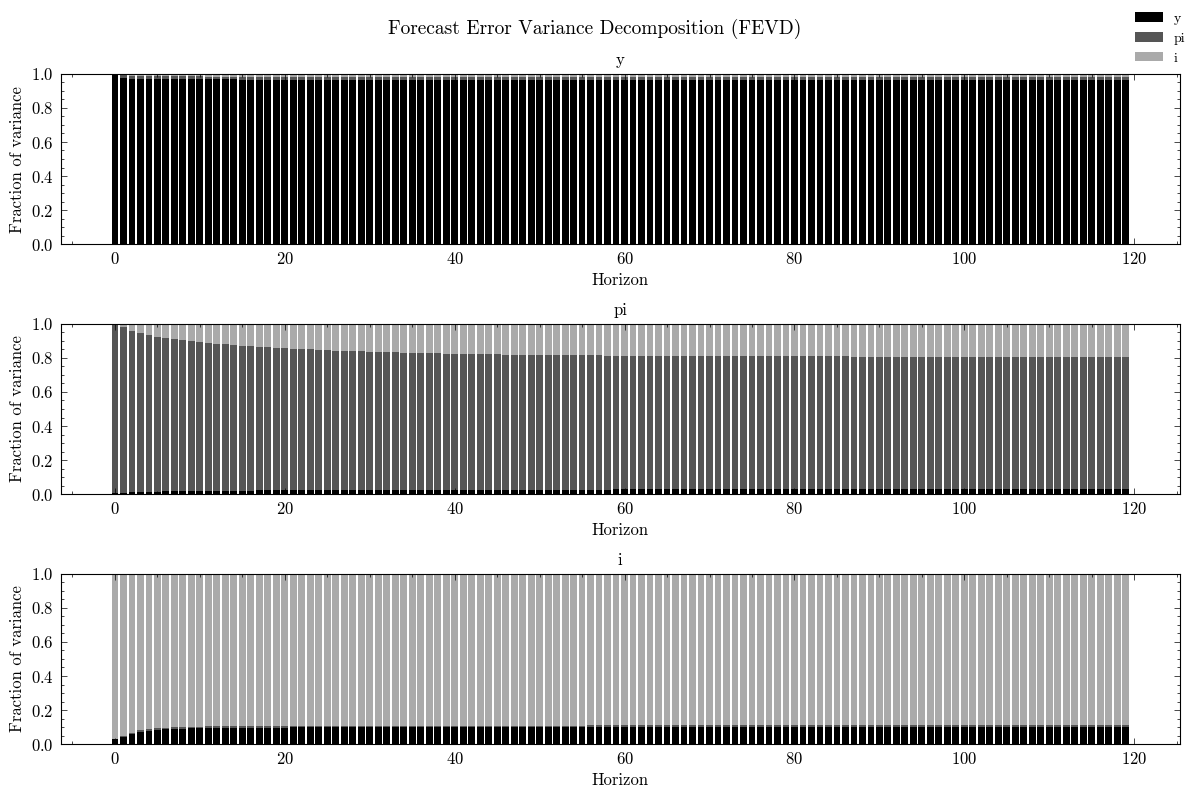

In [282]:
fig = fevd.plot(figsize=(12, 8))

colors = ["#4C72B0", "#55A868", "#C44E52"]  # blue, green, red


for ax in fig.axes:
    # Each stacked area is a PolyCollection
    for poly, color in zip(ax.collections, colors):
        poly.set_facecolor(color)
        poly.set_edgecolor("none")
        poly.set_alpha(0.9)

    ax.set_ylim(0, 1)
    ax.set_ylabel("Fraction of variance")
    ax.set_xlabel("Horizon")

fig.suptitle("Forecast Error Variance Decomposition (FEVD)", fontsize=14)
plt.tight_layout()
plt.savefig(f'../Figures/final/fevd.png', dpi = 600)
plt.show()

### 1.h

In [283]:


# 3) Get MA coefficients of reduced-form VAR
Phi = res.ma_rep(H) 

# 4) Convert to structural MA coefficients: Theta_k = Phi_k * P
# because u_t = P e_t and z_t = sum Phi_k u_{t-k} = sum (Phi_k P) e_{t-k}
Theta = [Phi_k @ B for Phi_k in Phi]  # each is (n x n)

# 5) Historical decomposition: contributions[t, var, shock]
idx = E.index
n = len(res.names)
T = len(idx)

contrib = np.zeros((T, n, n))

E_vals = E.values  # (T x n)

for t in range(T):
    for k in range(H+1):
        if t - k < 0:
            break
        contrib[t] += Theta[k] * E_vals[t-k]  # broadcasting: (n x n) * (n,) -> (n x n)

# Wrap into nice DataFrames per variable
var_names = res.names
shock_names = E.columns.tolist()

HD = {}
for vi, vname in enumerate(var_names):
    HD[vname] = pd.DataFrame(contrib[:, vi, :], index=idx, columns=shock_names)


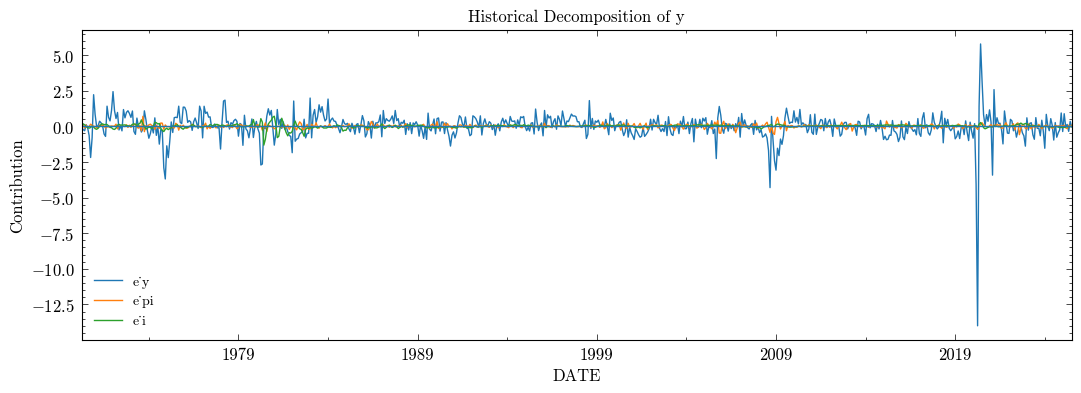

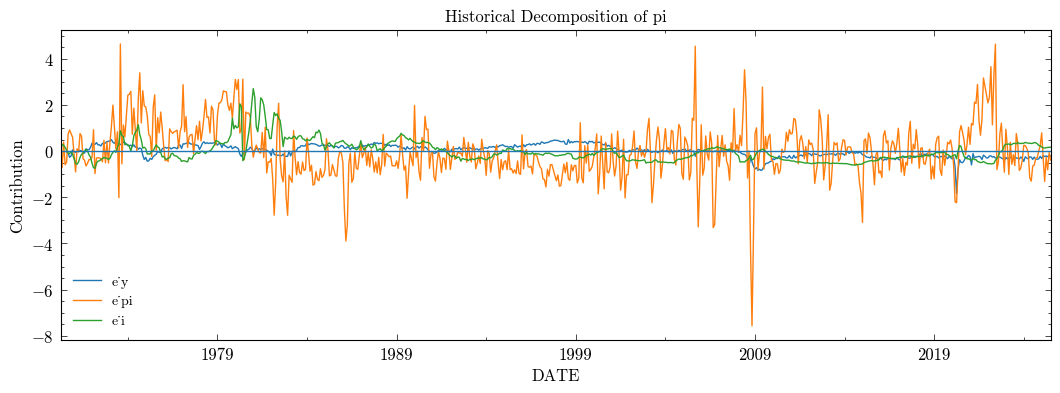

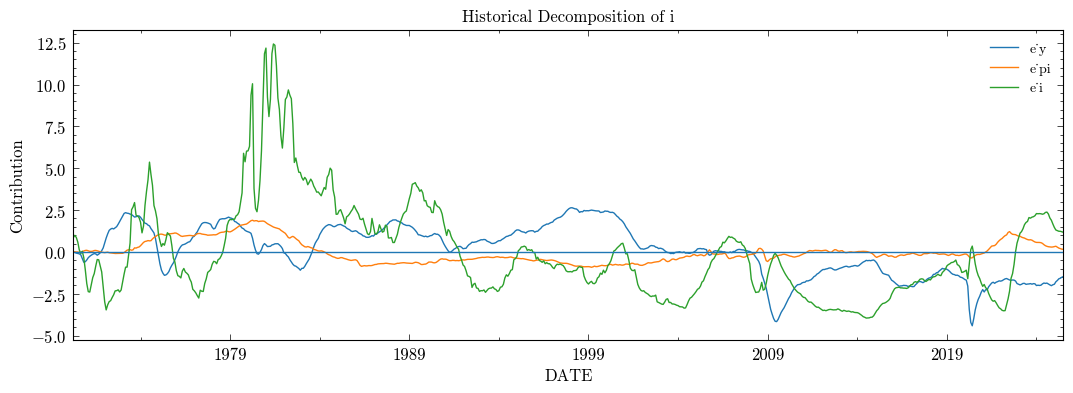

In [284]:
for vname in var_names:
    ax = HD[vname].plot(figsize=(12,4), title=f"Historical Decomposition of {vname}")
    ax.axhline(0, linewidth=1)
    ax.set_ylabel("Contribution")
    plt.savefig(f'../Figures/final/hd_{vname}.png', dpi = 600)
    plt.show()


In [285]:
H = 120  # 10 years in months
irf = res.irf(H)

# response of y to i-shock (Cholesky)
y_resp = irf.orth_irfs[:, res.names.index("y"), res.names.index("i")]

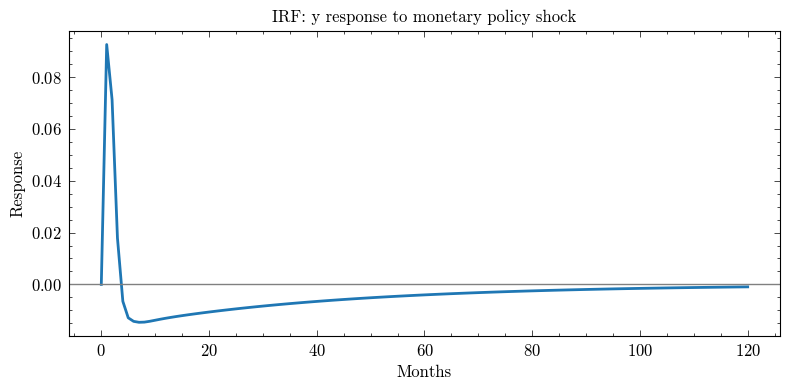

In [286]:
plt.figure(figsize=(8,4))
plt.plot(y_resp, linewidth=2)
plt.axhline(0, color="grey", linewidth=1)
plt.title("IRF: y response to monetary policy shock")
plt.xlabel("Months")
plt.ylabel("Response")
plt.tight_layout()

plt.savefig(f'../Figures/final/irf.png', dpi = 600)
plt.show()

## 4

In [287]:
iv_file = os.path.join(repo_root, 'data', 'Gertler-Karadi', 'factor_data.csv') 
iv = pd.read_csv(iv_file)

iv = iv.copy()

iv["DATE"] = pd.to_datetime(
    iv["year"].astype(str) + "-" + iv["month"].astype(str) + "-01"
)

iv = iv.set_index("DATE").sort_index().drop(columns=['year', 'month'])

In [288]:
iv

,mp1_tc,ff4_tc,ed2_tc,ed3_tc,ed4_tc
DATE,,,,,
1979-07-01,NaN,NaN,NaN,NaN,NaN
1979-08-01,NaN,NaN,NaN,NaN,NaN
1979-09-01,NaN,NaN,NaN,NaN,NaN
1979-10-01,NaN,NaN,NaN,NaN,NaN
1979-11-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2012-02-01,-0.003871,0.000000,-0.011613,-0.019355,-0.027097
2012-03-01,0.000000,0.000000,0.003065,0.009193,0.012258
2012-04-01,0.000000,0.000000,0.001935,0.005806,0.007742


In [289]:
df_merged = Z.merge(iv, left_index=True, right_index=True, how="left")

In [290]:
df_merged.dropna()

,y,pi,i,mp1_tc,ff4_tc,ed2_tc,ed3_tc,ed4_tc
DATE,,,,,,,,
1990-01-01,-0.507063,3.782534,8.23,-0.103636,0.000000,-0.018387,-0.012258,-0.012258
1990-02-01,0.904064,1.565560,8.24,-0.010500,-0.015000,0.015000,0.007500,0.007500
1990-03-01,0.496920,1.870619,8.28,-0.003500,-0.007581,0.002419,-0.000081,-0.001371
1990-04-01,-0.262325,0.932039,8.26,0.000000,-0.017419,-0.017419,-0.017419,-0.026129
1990-05-01,0.303690,0.620155,8.18,0.000000,0.000000,-0.010323,-0.010323,-0.010323
...,...,...,...,...,...,...,...,...
2012-02-01,0.321050,0.854066,0.10,-0.003871,0.000000,-0.011613,-0.019355,-0.027097
2012-03-01,-0.519117,0.836513,0.13,0.000000,0.000000,0.003065,0.009193,0.012258
2012-04-01,0.716776,0.663764,0.14,0.000000,0.000000,0.001935,0.005806,0.007742


In [292]:
Z = df_merged[['ff4_tc',
                'y',
               'pi',
                #  'i'
                 ]].dropna().rename(columns={'ff4_tc': 'w'})

In [293]:
Z

,w,y,pi
DATE,,,
1990-01-01,0.000000,-0.507063,3.782534
1990-02-01,-0.015000,0.904064,1.565560
1990-03-01,-0.007581,0.496920,1.870619
1990-04-01,-0.017419,-0.262325,0.932039
1990-05-01,0.000000,0.303690,0.620155
...,...,...,...
2012-02-01,0.000000,0.321050,0.854066
2012-03-01,0.000000,-0.519117,0.836513
2012-04-01,0.000000,0.716776,0.663764


In [294]:
model = VAR(Z)

/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [295]:
# pick lags (try AIC/BIC)
lag_sel = model.select_order(maxlags=12)
print(lag_sel.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.737      -6.696    0.001186      -6.721
1       -7.088      -6.922   0.0008354      -7.021
2       -7.232     -6.943*   0.0007232      -7.116
3      -7.290*      -6.876  0.0006827*     -7.123*
4       -7.275      -6.738   0.0006925      -7.059
5       -7.272      -6.611   0.0006952      -7.006
6       -7.259      -6.475   0.0007040      -6.944
7       -7.253      -6.344   0.0007092      -6.887
8       -7.225      -6.192   0.0007294      -6.810
9       -7.191      -6.034   0.0007551      -6.726
10      -7.181      -5.900   0.0007639      -6.666
11      -7.140      -5.735   0.0007965      -6.575
12      -7.150      -5.622   0.0007892      -6.536
--------------------------------------------------


In [296]:
p = lag_sel.selected_orders["bic"]  # or "aic"

res = model.fit(p)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Dec, 2025
Time:                     18:37:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.93065
Nobs:                     268.000    HQIC:                  -7.09902
Log likelihood:          -153.414    FPE:                0.000737679
AIC:                     -7.21204    Det(Omega_mle):     0.000682769
--------------------------------------------------------------------
Results for equation w
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.015106         0.004114           -3.672           0.000
L1.w          0.335257         0.061603            5.442           0.000
L1.y          0.006084         0.004498            1.353           0.176
L1.pi         0.002953 

In [297]:
U = res.resid.values              # u_t
Sigma_u = res.sigma_u.values      # Σ_u

B = np.linalg.cholesky(Sigma_u)   # Σ_u = B B'
E = U @ np.linalg.inv(B).T        # e_t = P^{-1} u_t


E = pd.DataFrame(E, index=res.resid.index, columns=[f"shock_{v}" for v in res.names])
# With ordering (y,pi,i): shock_i is monetary policy shock under recursive ID
E.columns = ["e_w",
              "e_y", 
             "e_pi", 
            # "e_i"
             ]

In [298]:
E

,e_w,e_y,e_pi
DATE,,,
1990-03-01,0.071814,0.689408,1.565531
1990-04-01,-0.301524,-1.240173,-0.688963
1990-05-01,0.361213,0.308794,-0.159982
1990-06-01,0.216194,0.394939,2.079996
1990-07-01,-1.349173,-0.957426,-0.021695
...,...,...,...
2012-02-01,0.139403,-0.171480,-0.422463
2012-03-01,0.179287,-1.351558,-0.228842
2012-04-01,0.314337,1.025381,-0.113042


In [299]:
em_t = E['e_w']
w_t = Z.loc[em_t.index, "w"]   

In [300]:
em_t

DATE
1990-03-01    0.071814
1990-04-01   -0.301524
1990-05-01    0.361213
1990-06-01    0.216194
1990-07-01   -1.349173
                ...   
2012-02-01    0.139403
2012-03-01    0.179287
2012-04-01    0.314337
2012-05-01    0.227216
2012-06-01    0.372127
Name: e_w, Length: 268, dtype: float64

In [301]:
em_std = (em_t - em_t.mean()) / em_t.std()
w_std  = (w_t  - w_t.mean())  / w_t.std()

corr = em_std.corr(w_std)
print(f"corr(e_m, w) = {corr:.3f}")

corr(e_m, w) = 0.934


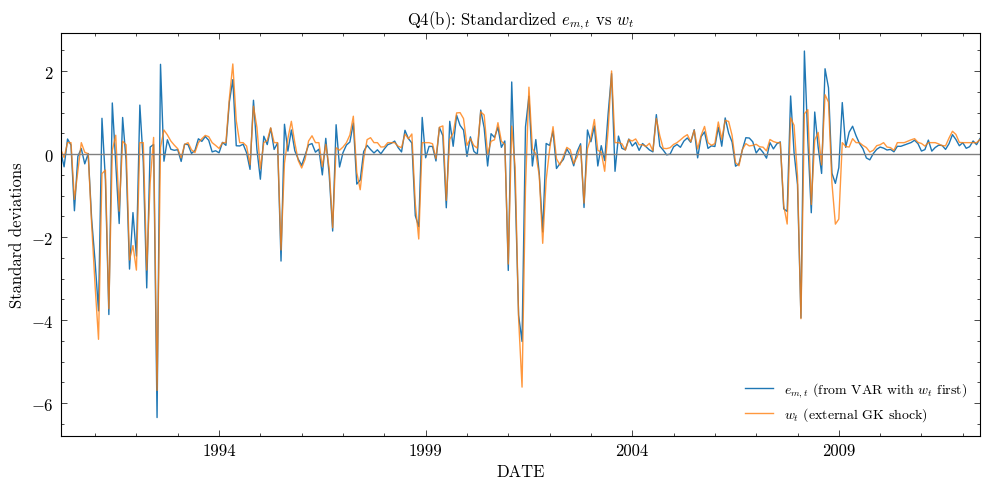

In [302]:
fig, ax = plt.subplots(figsize=(10, 5))

em_std.plot(ax=ax, linewidth=1, label=r"$e_{m,t}$ (from VAR with $w_t$ first)")
w_std.plot(ax=ax, linewidth=1, alpha=0.8, label=r"$w_t$ (external GK shock)")

ax.axhline(0, linewidth=1, color="grey")
ax.set_title("Q4(b): Standardized $e_{m,t}$ vs $w_t$")
ax.set_ylabel("Standard deviations")
ax.legend()

plt.tight_layout()
plt.savefig("../Figures/final/em_vs_w.png", dpi=600)
plt.show()

In [303]:
common_idx = em_t.index.intersection(mp_shock.index)



In [304]:
em_c = em_t.loc[common_idx]
ei_c  = mp_shock.loc[common_idx]

em_std = (em_t - em_t.mean()) / em_t.std()
ei_std  = (ei_c  - ei_c.mean())  / ei_c.std()

corr = em_std.corr(ei_std)
print(f"corr(e_m, w) = {corr:.3f}")

corr(e_m, w) = 0.445


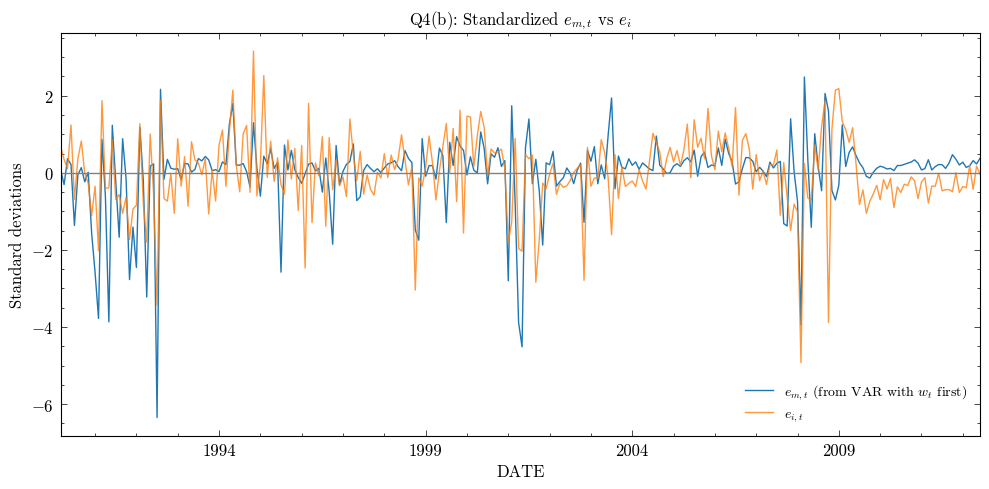

In [305]:
fig, ax = plt.subplots(figsize=(10, 5))

em_std.plot(ax=ax, linewidth=1, label=r"$e_{m,t}$ (from VAR with $w_t$ first)")
ei_std.plot(ax=ax, linewidth=1, alpha=0.8, label=r"$e_{i,t}$ ")

ax.axhline(0, linewidth=1, color="grey")
ax.set_title("Q4(b): Standardized $e_{m,t}$ vs $e_{i}$")
ax.set_ylabel("Standard deviations")
ax.legend()

plt.tight_layout()
plt.savefig("../Figures/final/em_vs_ei.png", dpi=600)
plt.show()

In [306]:
H = 120  # 10 years in months
irf = res.irf(H)

# response of y to i-shock (Cholesky)
y_resp = irf.orth_irfs[:, res.names.index("y"), res.names.index("w")]


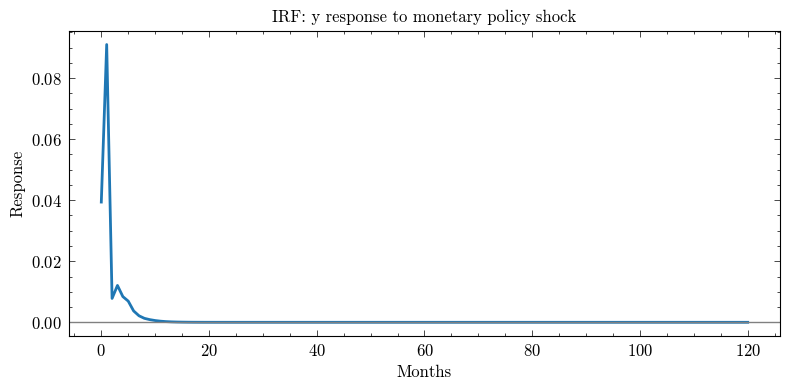

In [307]:
plt.figure(figsize=(8,4))
plt.plot(y_resp, linewidth=2)
plt.axhline(0, color="grey", linewidth=1)
plt.title("IRF: y response to monetary policy shock")
plt.xlabel("Months")
plt.ylabel("Response")
plt.tight_layout()

plt.savefig(f'../Figures/final/irf_iv.png', dpi = 600)
plt.show()

In [308]:
H = 120 
fevd = res.fevd(H)

In [309]:
fevd.summary()

FEVD for w
              w         y        pi
0      1.000000  0.000000  0.000000
1      0.991692  0.005107  0.003201
2      0.980957  0.011591  0.007452
3      0.976418  0.015116  0.008465
4      0.974544  0.016970  0.008485
5      0.973781  0.017740  0.008479
6      0.973500  0.018024  0.008476
7      0.973396  0.018126  0.008478
8      0.973354  0.018166  0.008480
9      0.973337  0.018183  0.008480
10     0.973330  0.018190  0.008480
11     0.973327  0.018193  0.008480
12     0.973326  0.018194  0.008480
13     0.973326  0.018194  0.008480
14     0.973325  0.018194  0.008480
15     0.973325  0.018194  0.008480
16     0.973325  0.018194  0.008480
17     0.973325  0.018194  0.008480
18     0.973325  0.018194  0.008480
19     0.973325  0.018194  0.008480
20     0.973325  0.018194  0.008480
21     0.973325  0.018194  0.008480
22     0.973325  0.018194  0.008480
23     0.973325  0.018194  0.008480
24     0.973325  0.018194  0.008480
25     0.973325  0.018194  0.008480
26     0.973325  

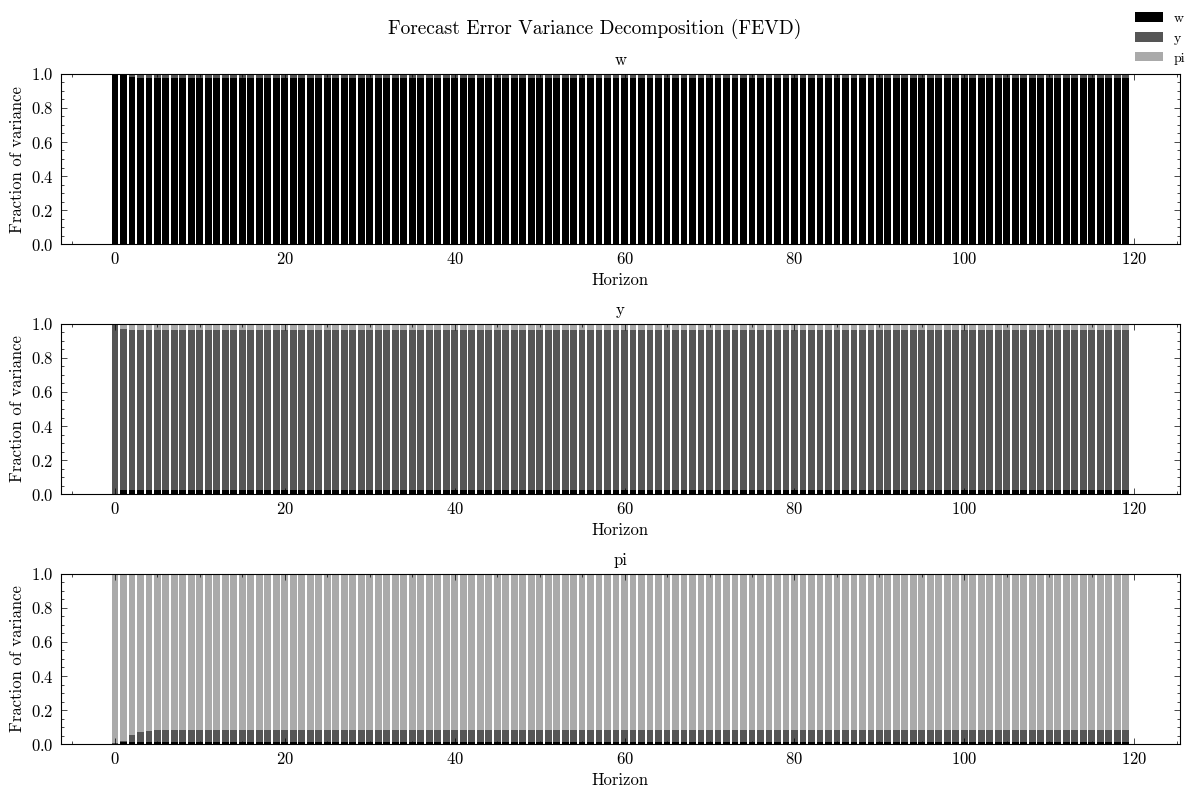

In [310]:
fig = fevd.plot(figsize=(12, 8))

colors = ["#4C72B0", "#55A868", "#C44E52"]  # blue, green, red


for ax in fig.axes:
    # Each stacked area is a PolyCollection
    for poly, color in zip(ax.collections, colors):
        poly.set_facecolor(color)
        poly.set_edgecolor("none")
        poly.set_alpha(0.9)

    ax.set_ylim(0, 1)
    ax.set_ylabel("Fraction of variance")
    ax.set_xlabel("Horizon")

fig.suptitle("Forecast Error Variance Decomposition (FEVD)", fontsize=14)
plt.tight_layout()
plt.savefig(f'../Figures/final/fevd_iv.png', dpi = 600)
plt.show()

In [311]:

# 3) Get MA coefficients of reduced-form VAR
Phi = res.ma_rep(H) 

# 4) Convert to structural MA coefficients: Theta_k = Phi_k * P
# because u_t = P e_t and z_t = sum Phi_k u_{t-k} = sum (Phi_k P) e_{t-k}
Theta = [Phi_k @ B for Phi_k in Phi]  # each is (n x n)

# 5) Historical decomposition: contributions[t, var, shock]
idx = E.index
n = len(res.names)
T = len(idx)

contrib = np.zeros((T, n, n))

E_vals = E.values  # (T x n)

for t in range(T):
    for k in range(H+1):
        if t - k < 0:
            break
        contrib[t] += Theta[k] * E_vals[t-k]  # broadcasting: (n x n) * (n,) -> (n x n)

# Wrap into nice DataFrames per variable
var_names = res.names
shock_names = E.columns.tolist()

HD = {}
for vi, vname in enumerate(var_names):
    HD[vname] = pd.DataFrame(contrib[:, vi, :], index=idx, columns=shock_names)

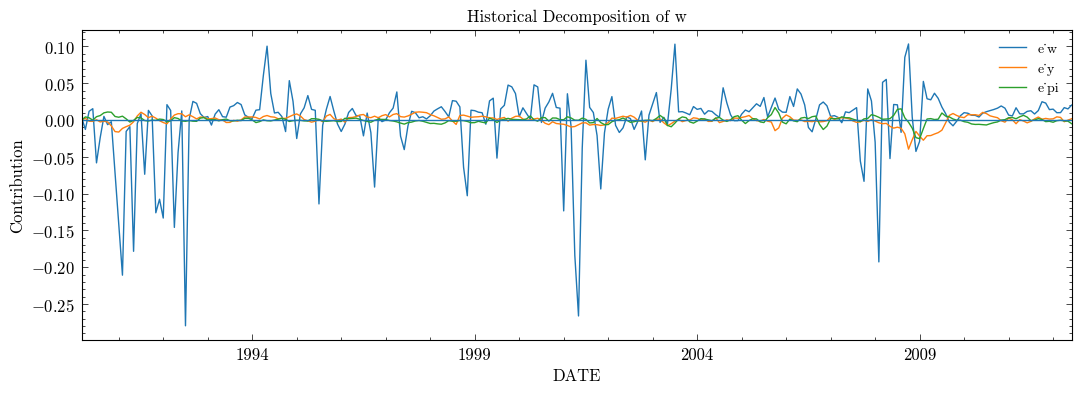

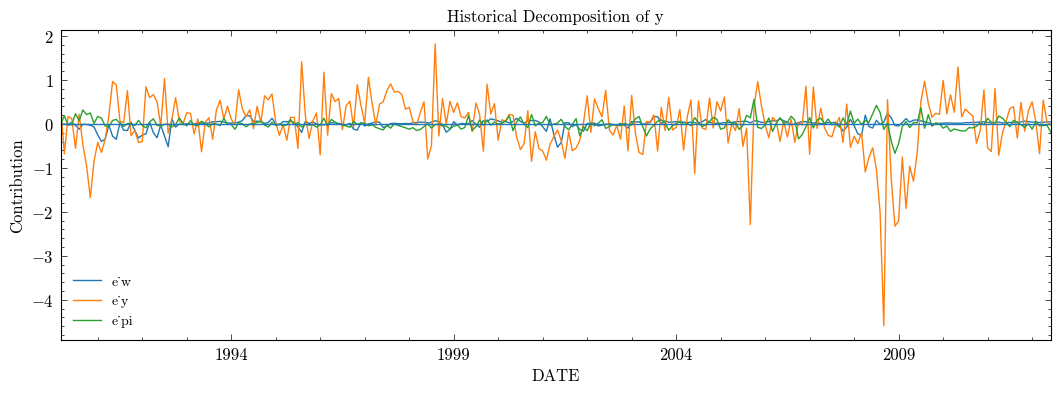

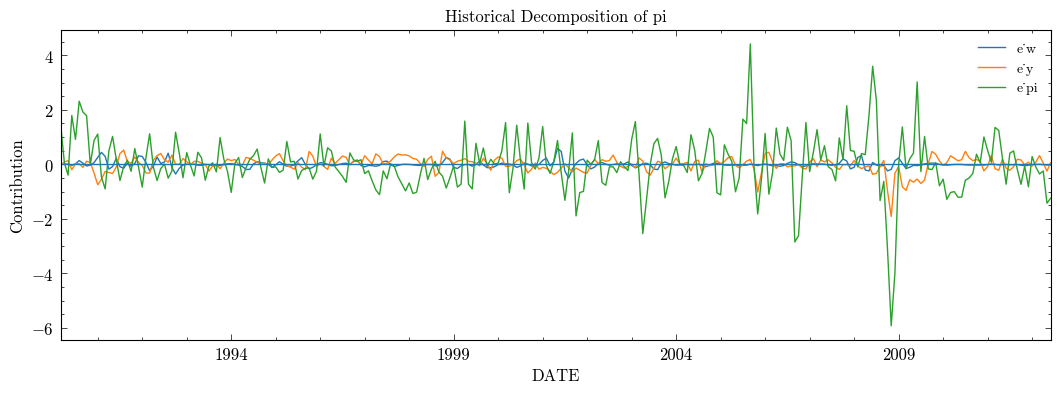

In [312]:
for vname in var_names:
    ax = HD[vname].plot(figsize=(12,4), title=f"Historical Decomposition of {vname}")
    ax.axhline(0, linewidth=1)
    ax.set_ylabel("Contribution")
    plt.savefig(f'../Figures/final/hd_{vname}_iv.png', dpi = 600)
    plt.show()